In [ ]:
# Importing Libraries

from functions.final_functions import * 
from spectral import *
from functions.dataset_functions import *
from models.models import *
from functions.augmentations import *


In [ ]:
# Loading Electrolyzers-HSI

output_dir = "Path to Electrolyzers dataset/Electrolyzers-HSI"

HSI, RGB, GT = load_triplets(output_dir)
print(HSI[50].shape,  RGB[50].shape, GT[50].shape)

# Spectral Binning 360 bands --> 180 bands
HSI = spectral_binning(HSI)
print(HSI[50].shape,  RGB[50].shape, GT[50].shape)

# Apply vector-wise normalization with mask to all HSIs
normalized_HSI_bandwise = [normalize_hsi_vector_wise_with_mask(hsi, gt) for hsi, gt in zip(HSI, GT)]

# Test split
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
# Test Data Generation
test, test_GT, test_rgb = Generate_data(test_indices, normalized_HSI_bandwise, GT, RGB)
print(len(test),test[0].shape,test_GT[0].shape,np.unique(test_GT[0]))

(250, 370, 360) (250, 370, 3) (250, 370)
(250, 370, 180) (250, 370, 3) (250, 370)
11 (240, 325, 180) (240, 325) [0 1 2 3]


In [6]:
# Setup the Test Dastset and Dataloader Classes

from torch.utils.data import DataLoader
from models.models import HSIDataset

# Set parameters
patch_size = 9 
band_patch = 1 
num_classes = 5

# Test Dataset Class instance
test_dataset = HSIDataset(test, test_GT, patch_size, ignore_classes=[0], band_patch = band_patch)

# Test Dataloader Class instance
label_test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Test set is finished 

Test patches: Original - 92315


In [ ]:
# Environment Setup and Model Calling and Hyperparameters
from models.models import ViT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 200
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
hsi_bands = test[0].shape[-1]

model = ViT(
    image_size = patch_size, 
    near_band = band_patch, 
    num_patches = hsi_bands, 
    num_classes = num_classes,
    dim = 64, 
    depth = 5, 
    heads = 4, 
    mlp_dim = 8,
    dropout = 0.5, 
    emb_dropout = 0.2, 
    mode = 'ViT'
)
model = model.cuda()

# The path to the trained VisionTransformer weights
path = 'weights/ViT_180.pth' # or others

# Load the trained VisionTransformer weights
model.load_state_dict(torch.load(path))

# Move the model to the GPU if available
model.to(device)

# Set the model in evaluation mode: disables certain training-related features
model.eval()

# Initialize lists to store predicted masks
predictions = []
all_labels = []
# Iterate over the test images and their ground truth masks
for patch, label in label_test_loader:
        
    # Move the data to GPU
    patch = patch.to(device)  # Transfer the image data to the specified device
    #masks = masks.type(torch.LongTensor)  # Convert the ground truth masks to LongTensor format
    label = label.to(device)  # Transfer the ground truth masks to the specified device

#     # Perform inference
    with torch.no_grad():  # Forward pass the images through the model to obtain the predictions
        output = model(patch)  # Forward pass the images through the model to obtain the predictions 

    output = torch.nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    # Transfer the output to CPU memory and convert it to a numpy array
    predicted_label = output.cpu().numpy()  
    
    # Append the predicted mask to the list
    predictions.append(predicted_label)
    all_labels.append(label.cpu().flatten())
    

predictions = np.concatenate(predictions)
testing_label = np.concatenate(all_labels)
#print(np.unique(predictions), np.unique(testing_label))

confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class, pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(testing_label, predictions, 5)

print("F1 Score:")
print(f1_score)
evaluate_segmentation2(testing_label, predictions, 5)

5
[0 1 2 3 4] [0 1 2 3 4]
F1 Score:
[0.75878076 0.27422378 0.45767872 0.31737346 0.38484915]


{'confusion_matrix_sum': array([[27134,  3467,  3867,  1942,   504],
        [ 1275,  4023,  1148,  1202,  4793],
        [ 3746,  2531,  7516,   899,  1331],
        [ 1559,  1399,  1814,  3016,  2361],
        [  892,  5480,  2476,  1798,  6142]]),
 'true_positive_sum': array([27134,  4023,  7516,  3016,  6142]),
 'true_negative_sum': array([0, 0, 0, 0, 0]),
 'false_positive_sum': array([ 7472, 12877,  9305,  5841,  8989]),
 'false_negative_sum': array([ 9780,  8418,  8507,  7133, 10646]),
 'precision': array([0.78408368, 0.23804734, 0.44682242, 0.34052162, 0.40592162]),
 'recall': array([0.73505987, 0.32336629, 0.4690757 , 0.29717214, 0.36585656]),
 'f1_score': array([0.75878076, 0.27422378, 0.45767872, 0.31737346, 0.38484915]),
 'pixel_accuracy_per_class': array([0.73505987, 0.32336629, 0.4690757 , 0.29717214, 0.36585656]),
 'pixel_accuracy (OA)': 0.5181281481882685,
 'iou': array([0.61131888, 0.15889881, 0.29674668, 0.18861789, 0.23827443]),
 'dice_coefficient': array([0.75878076,

<Figure size 864x576 with 0 Axes>

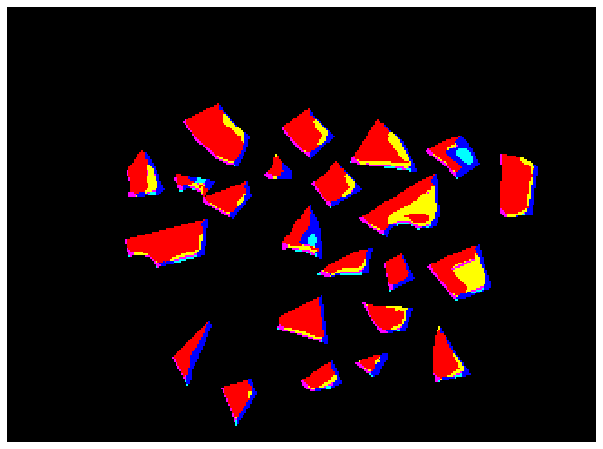

<Figure size 864x576 with 0 Axes>

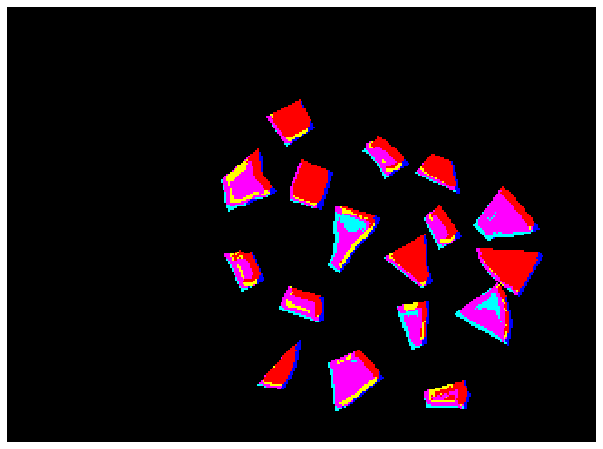

<Figure size 864x576 with 0 Axes>

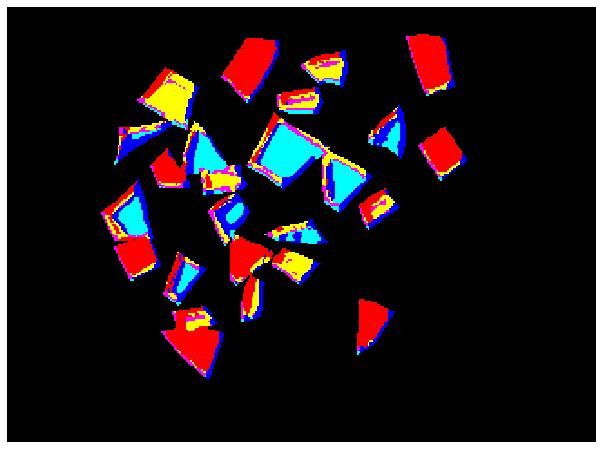

<Figure size 864x576 with 0 Axes>

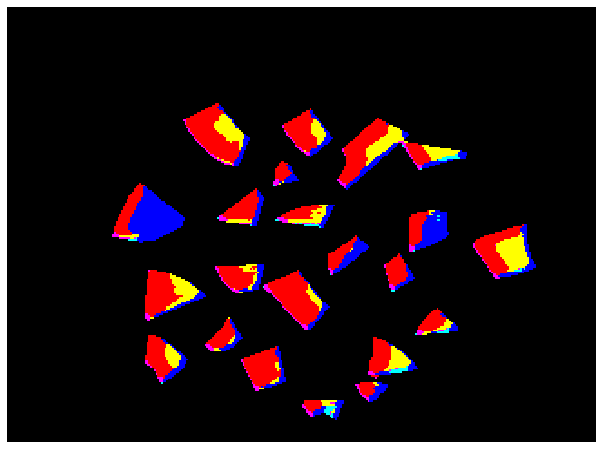

In [9]:
# VisionTransformer Classification Results Visualization

import matplotlib.pyplot as plt

# test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
prediction_masks = reconstruct_predictions(test_GT, predictions)
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(0)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(46)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(41)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(5)])


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

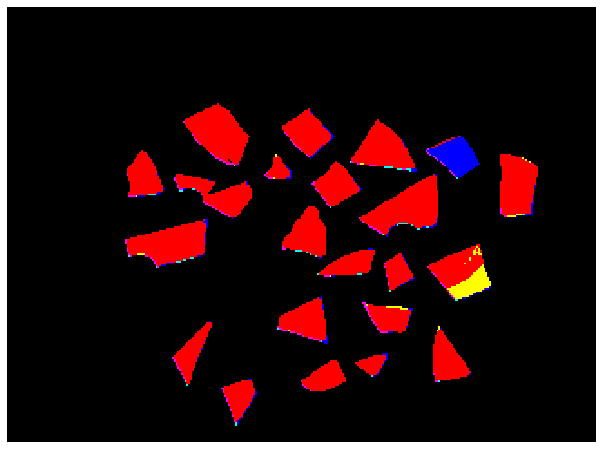

<Figure size 864x576 with 0 Axes>

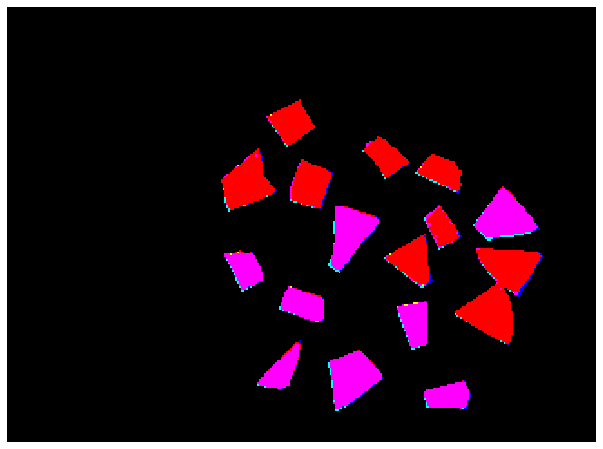

<Figure size 864x576 with 0 Axes>

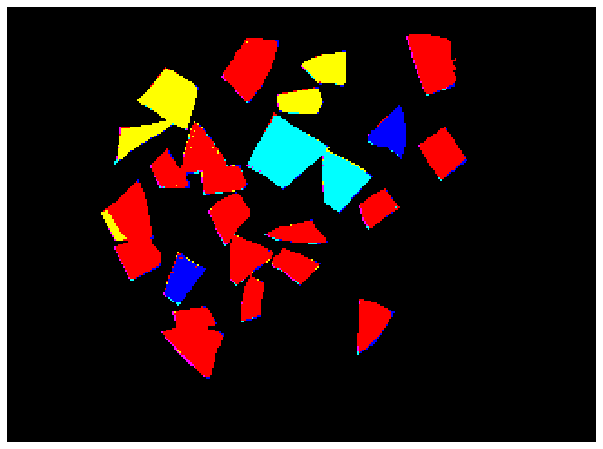

<Figure size 864x576 with 0 Axes>

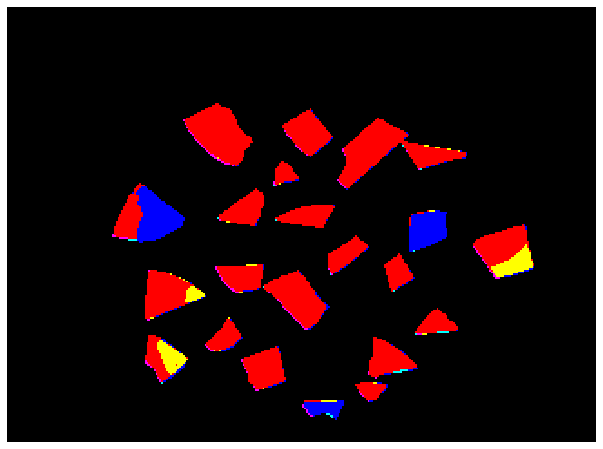

In [10]:
# Majority voting from zero-shot segmentation masks
objects = []
for i in test_indices:
    objects.append(load_and_decompress("zero-shot/" + str(i) +".pkl"))
    
# Apply with debugging
majority_voted_masks = majority_voting_with_segmentation(prediction_masks, objects, area = 10)

# Visualization (assuming your visualize_mask function works)
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
plt.figure(figsize=(12,8))
for idx in [0, 46, 41, 5]:
    plt.figure(figsize=(12,8))
    visualize_mask(majority_voted_masks[test_indices.index(idx)])
plt.show()

In [11]:
# VisionTransformer Object-wise Classification Numerical Evaluation

metrics = calculate_segmentation_metrics(test_GT, majority_voted_masks)
print(f"Average F1-score: {metrics['average_f1_score']:.4f}")
print(f"F1-scores per class: {[f'{score:.4f}' for score in metrics['f1_scores_per_class']]}")
print(f"Average Accuracy (AA): {metrics['average_accuracy']:.4f}")
print(f"Kappa: {metrics['kappa']:.4f}")
print(f"Pixel Accuracy (OA): {metrics['pixel_accuracy']:.4f}")


Average F1-score: 0.7160
F1-scores per class: ['0.9991', '0.8300', '0.5885', '0.6481', '0.5140']
Average Accuracy (AA): 0.6832
Kappa: 0.8589
Pixel Accuracy (OA): 0.9810
